# Dependencies

In [166]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

from matplotlib.ticker import FuncFormatter

# Definitions and Data

In [3]:
# load dataset
#scraping wikipedia to fetch S&P 500 and DJI stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)[0]
SP_tickers = SP_stocks['Symbol'].to_list()

DJI = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
)
DJI_symbols = DJI.Symbol.tolist()

In [199]:
def download_stocks(tickers,start='2014-01-01',end='2019-01-01'):
    return yf.download(tickers, start = start, end = end)

def remove_null(df, cutoff = .99):
    df = df.dropna(thresh=int(df.shape[0]*cutoff),axis=1)
    df = df.dropna(thresh=int(df.shape[1]*cutoff))
    return df

def winsorize(df,q=.025):
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    
    train_size = int(len(df)*percentage)
    train_set = df[:train_size]
    test_set = df[train_size:]
    
    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)
    
    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)
    
    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)
    
    return train, test


def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
    0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        #sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = pd.concat([sort_idx,df0])
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

def clustered_corr_plot(df,include_ticks = True):
    corr = df.corr()
    
    distance_matrix = get_distance_matrix(corr)
    linkage_matrix = linkage(squareform(distance_matrix), 'single')
    sorted_idx = quasi_diagonalize(linkage_matrix)
    
    clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             center=0);
    plt.close()
    
    sorted_idx = clustergrid.dendrogram_row.reordered_ind
    sorted_tickers = corr.index[sorted_idx].tolist()
    fig, ax = plt.subplots(figsize=(18, 8))

    #sns.heatmap(corr, center = 0, ax=axes[0])
    #axes[0].set_title('Correlation Matrix')
    #fig.tight_layout()

    clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
    
    sns.heatmap(clustered_assets, center = 0, ax=ax)
    ax.set_title('Clustered Correlation')
    if not include_ticks:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout();
    
    return fig

In [388]:
SP_index = download_stocks('^GSPC')['Adj Close']
DJI_index = download_stocks('^DJI')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [389]:
SP_idx_returns = SP_index.pct_change().dropna()
DJI_idx_returns = DJI_index.pct_change().dropna()

In [5]:
SP_data = download_stocks(SP_tickers)['Adj Close']
SP_data.index = pd.to_datetime(SP_data.index)

DJI_data = download_stocks(DJI_symbols)['Adj Close']
DJI_data.index = pd.to_datetime(DJI_data.index)

SP_data = remove_null(SP_data)
DJI_data = remove_null(DJI_data)

[*********************100%***********************]  503 of 503 completed

11 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- CTVA: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- OTIS: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- OGN: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- FOXA: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- FOX: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- CEG: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- BF.B: No data found for this date range, symbol may be delisted
- CARR: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- DOW: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
- GEHC: Data doesn't exist for startDate = 1388552400, endDate = 1546318800
[*********************100%***********************]  30 of 30 completed

1 Failed download:
- DOW: Data doesn

In [6]:
print(SP_data.isna().sum().sum())
print(DJI_data.isna().sum().sum())

0
0


# Data Processing

In [7]:
#SP_returns = SP_data.pct_change().dropna()
#dji_returns = dji_data.pct_change().dropna()

#SP_log_returns = np.log(SP_data/SP_data.shift(1))[1:]
#dji_log_returns = np.log(dji_data/dji_data.shift(1))[1:]
#
#SP_log_returns = winsorize(SP_log_returns)
#dji_log_returns = winsorize(dji_log_returns)

SP_returns = SP_data.pct_change().dropna()
DJI_returns = DJI_data.pct_change().dropna()

SP_returns = winsorize(SP_returns)
DJI_returns = winsorize(DJI_returns)

In [263]:
#SP_train, SP_test = train_test_split(SP_log_returns)
#dji_train, dji_test = train_test_split(dji_log_returns)

SP_train, SP_test = train_test_split(SP_returns)
DJI_train, DJI_test = train_test_split(DJI_returns)

In [35]:
SP_train_scaled = (SP_train-SP_train.mean())/SP_train.std()
SP_test_scaled = (SP_test-SP_train.mean())/SP_train.std()

DJI_train_scaled = (DJI_train-DJI_train.mean())/DJI_train.std()
DJI_test_scaled = (DJI_test-DJI_train.mean())/DJI_train.std()

In [36]:
print('Statistics for SP-500 train set')
print(f'Average normalized return: {SP_train_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_train_scaled.std().mean()}')
print('\n')
print('Statistics for SP-500 test set')
print(f'Average normalized return: {SP_test_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_test_scaled.std().mean()}')

Statistics for SP-500 train set
Average normalized return: 3.107261222725643e-19
Average standard deviation: 1.0


Statistics for SP-500 test set
Average normalized return: -0.049199539218343045
Average standard deviation: 1.133007106043806


In [37]:
print('Statistics for DJI train set')
print(f'Average normalized return: {DJI_train_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_train_scaled.std().mean()}')
print('\n')
print('Statistics for DJI test set')
print(f'Average normalized return: {DJI_test_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_test_scaled.std().mean()}')

Statistics for DJI train set
Average normalized return: -5.637776896363806e-19
Average standard deviation: 0.9999999999999998


Statistics for DJI test set
Average normalized return: -0.02921268753121596
Average standard deviation: 1.2158627457064923


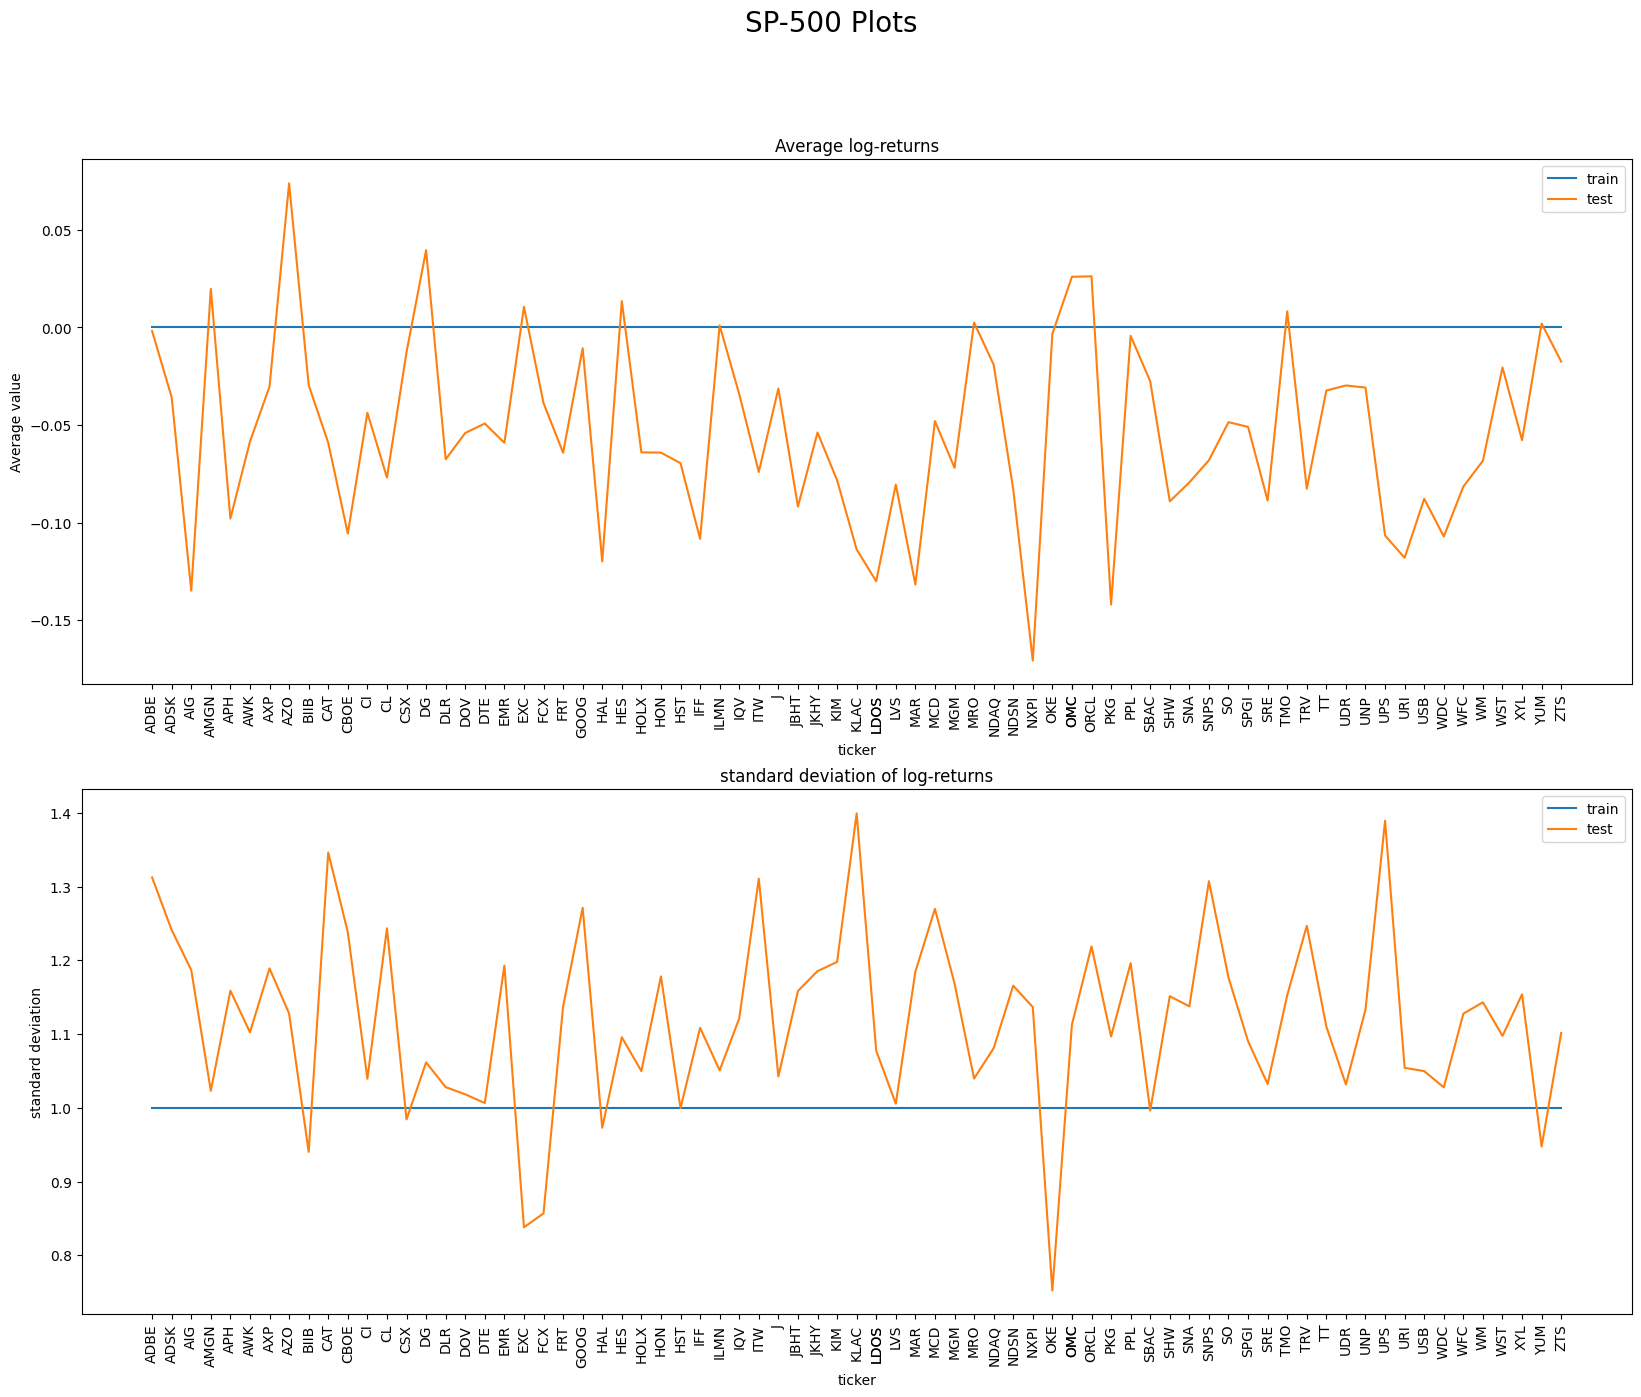

In [38]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

np.random.seed(110)

random_stocks = sorted(np.random.choice(SP_train_scaled.shape[1],75))
random_tickers = list(SP_train_scaled.columns[random_stocks])

SP_train_scaled_sample = SP_train_scaled[random_tickers]
SP_test_scaled_sample = SP_test_scaled[random_tickers]

axes[0].plot(SP_train_scaled_sample.mean(),label='train')
axes[0].plot(SP_test_scaled_sample.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
axes[0].set_xticks(random_tickers)
axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(SP_train_scaled_sample.std(),label='train')
axes[1].plot(SP_test_scaled_sample.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')
axes[1].set_xticks(random_tickers)
axes[1].set_xticklabels(random_tickers,rotation=90);

plt.suptitle('SP-500 Plots',fontsize=20)

plt.show();

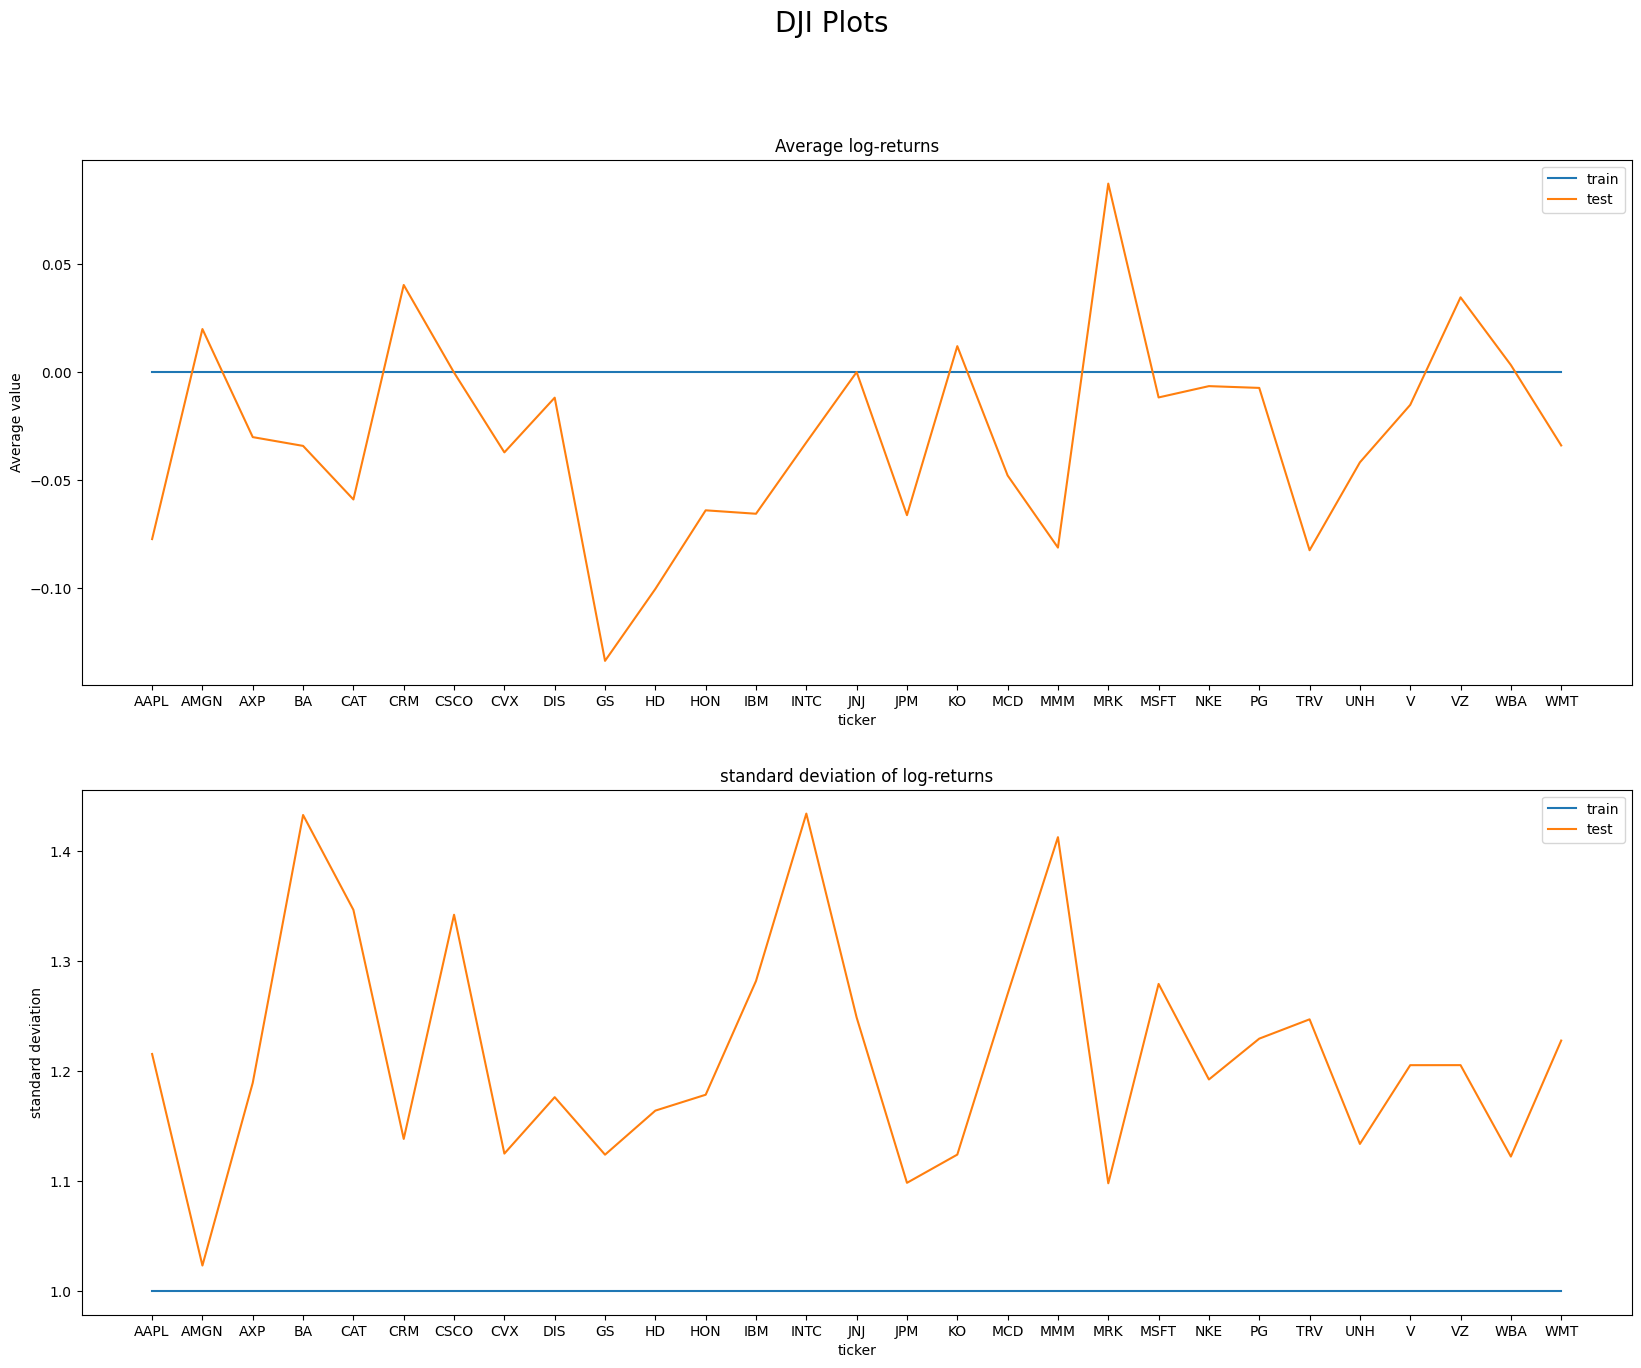

In [39]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

axes[0].plot(DJI_train_scaled.mean(),label='train')
axes[0].plot(DJI_test_scaled.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
#axes[0].set_xticks(random_tickers)
#axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(DJI_train_scaled.std(),label='train')
axes[1].plot(DJI_test_scaled.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')


plt.suptitle('DJI Plots',fontsize=20)

plt.show();

In [162]:
SP_train_cov = SP_train.cov()
SP_test_cov = SP_test.cov()

SP_train_corr = SP_train.corr()
SP_test_corr = SP_test.corr()

DJI_train_cov = DJI_train.cov()
DJI_test_cov = DJI_test.cov()

DJI_train_corr = DJI_train.corr()
DJI_test_corr = DJI_test.corr()

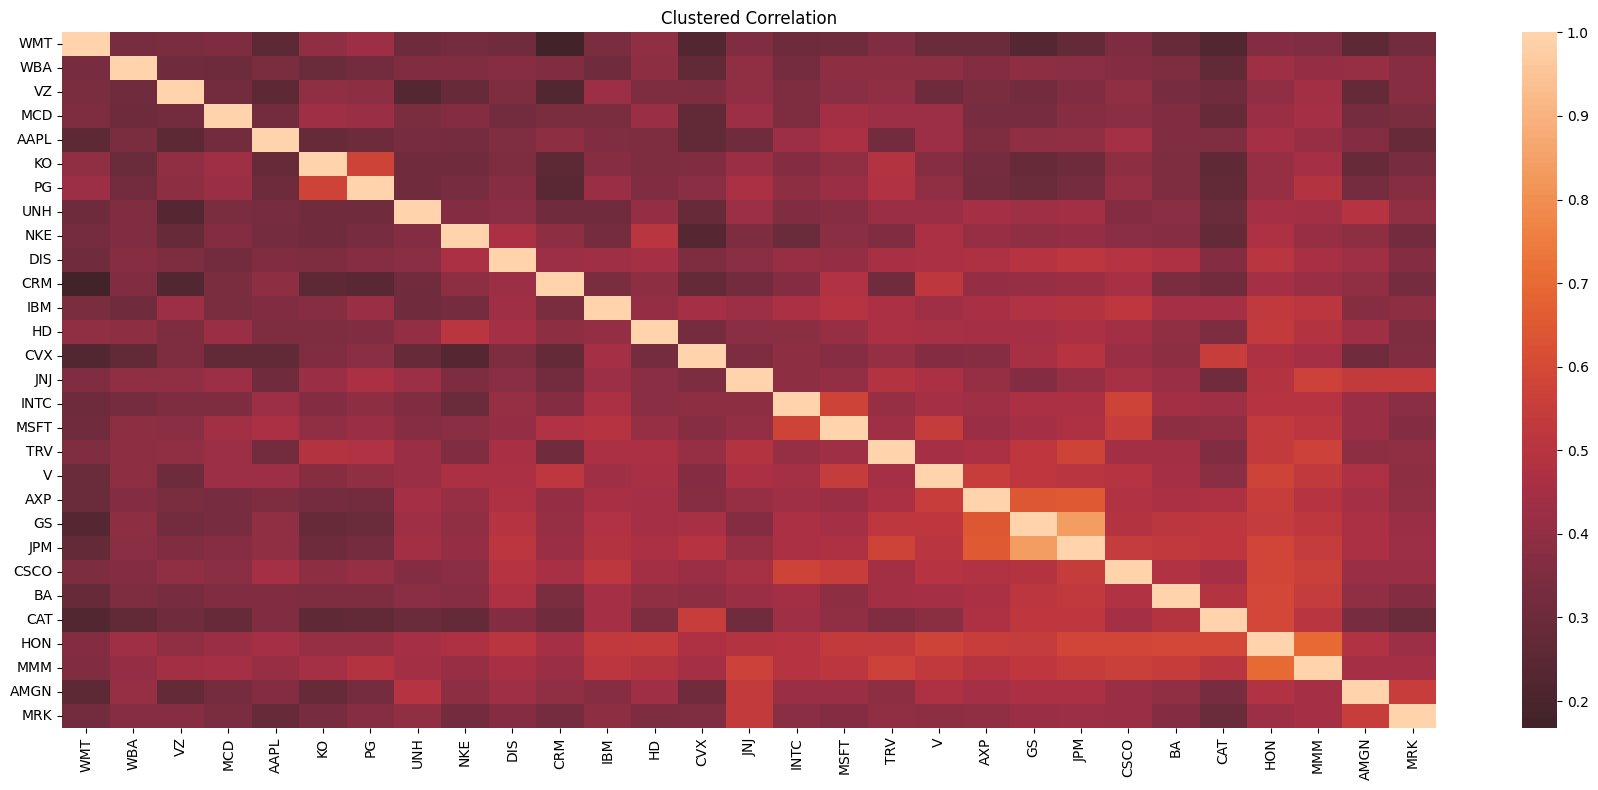

In [198]:
clustered_corr_plot(DJI_train);

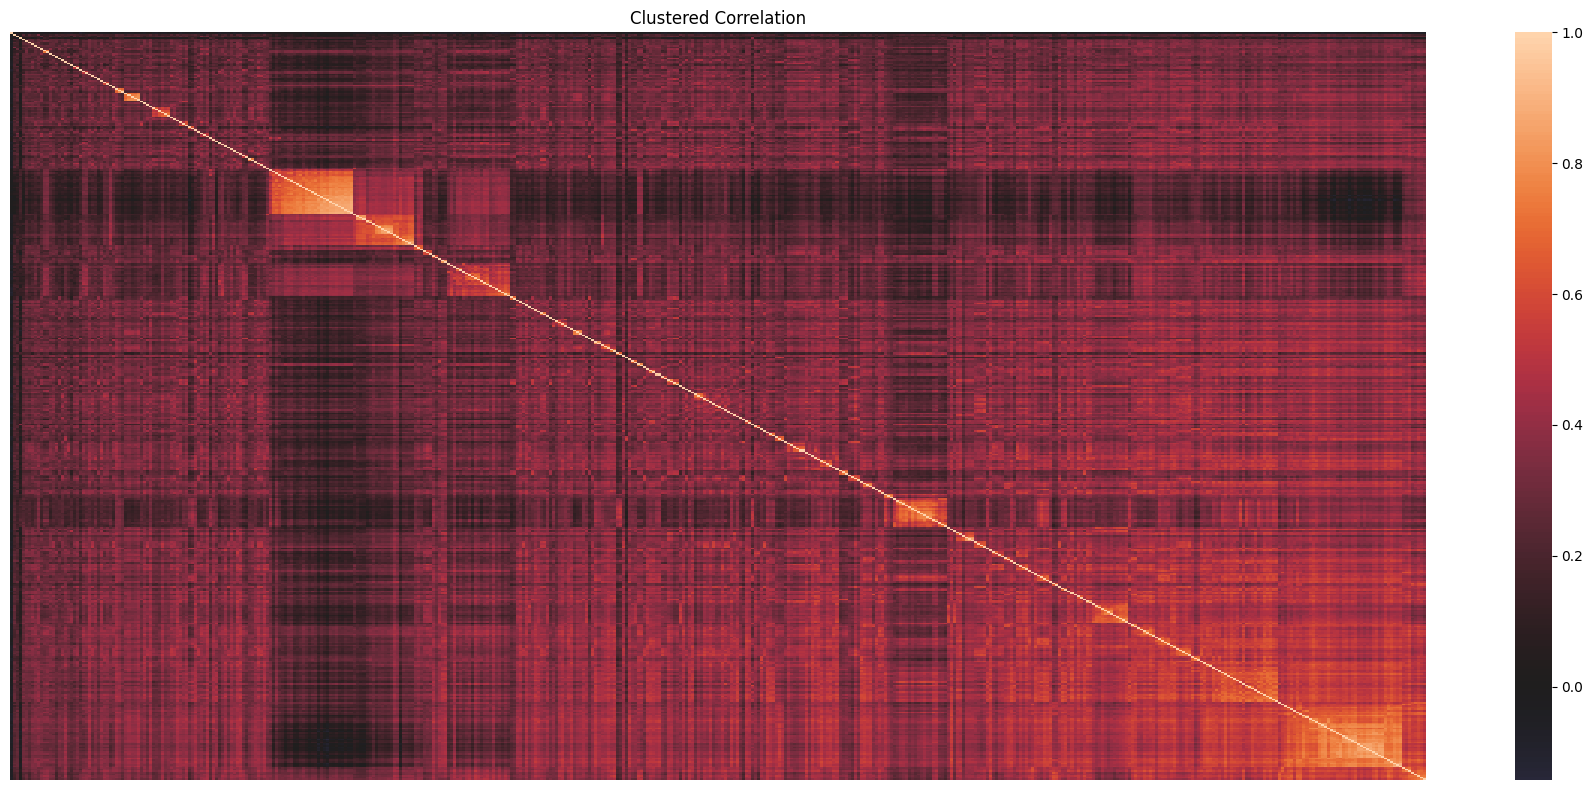

In [200]:
clustered_corr_plot(SP_train,include_ticks=False);

In [141]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(DJI_train_scaled)

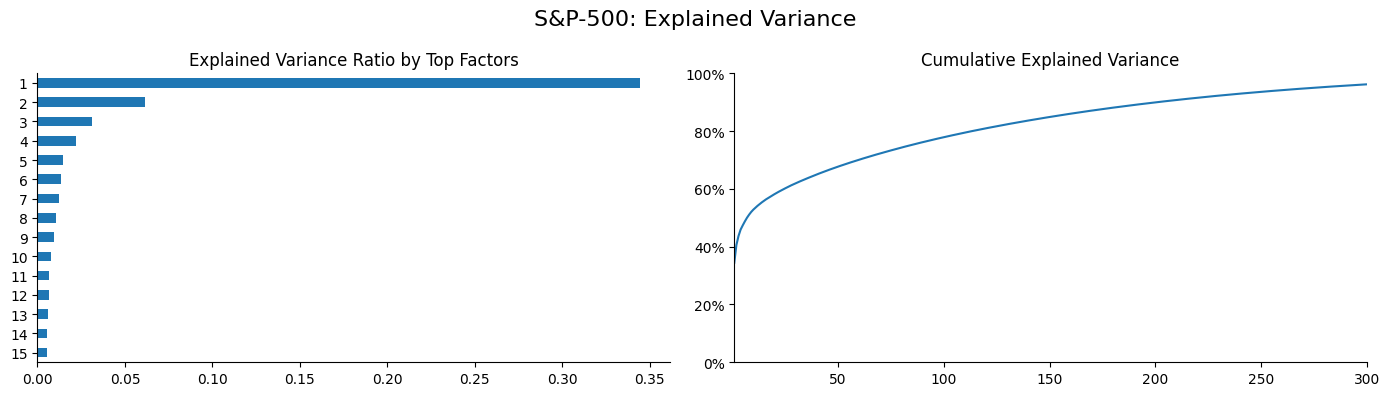

In [142]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_SP.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("S&P-500: Explained Variance", size=16)
fig.tight_layout()

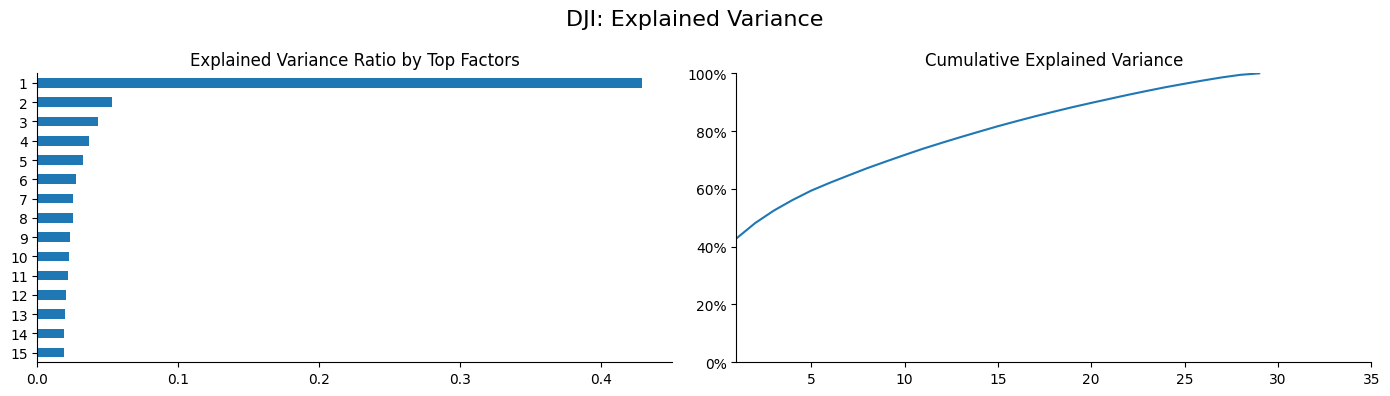

In [143]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_DJI.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 35))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("DJI: Explained Variance", size=16)
fig.tight_layout()

In [412]:
DJI_eigvals, DJI_eigvecs = np.linalg.eigh(DJI_train_corr)

DJI_eigvals = DJI_eigvals[::-1]
DJI_eigvecs = DJI_eigvecs[:,::-1]

print(np.allclose(PCA_DJI.explained_variance_ratio_,(DJI_eigvals/np.sum(DJI_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_DJI.components_,DJI_eigvecs)),
            np.eye(DJI_eigvecs.shape[0])))

True
True


In [413]:
SP_eigvals, SP_eigvecs = np.linalg.eigh(SP_train_corr)

SP_eigvals = SP_eigvals[::-1]
SP_eigvecs = SP_eigvecs[:,::-1]

print(np.allclose(PCA_SP.explained_variance_ratio_,(SP_eigvals/np.sum(SP_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_SP.components_,SP_eigvecs)),
            np.eye(SP_eigvecs.shape[0])))

True
True


In [414]:
SP_eigvecs[:,0].dot(SP_eigvecs[:,0])

0.9999999999999991

In [415]:
DJI_eigvecs[:,0].dot(DJI_eigvecs[:,0])

0.9999999999999999

In [417]:
DJI_evecs_std = (DJI_eigvecs.T/(DJI_train.std().values)).T

np.allclose((DJI_train.dot(DJI_evecs_std)).corr().values,np.eye(DJI_evecs_std.shape[0]))

True

In [418]:
SP_evecs_std = (SP_eigvecs.T/(SP_train.std().values)).T

np.allclose((SP_train.dot(SP_evecs_std)).corr().values,np.eye(SP_evecs_std.shape[0]))

True

In [ ]:
np.sum(DJI_evecs_std[:,0]/DJI_evecs_std[:,0].sum())

0.9999999999999997

In [479]:
for i in range(DJI_evecs_std.shape[1]):
    DJI_evecs_std[:,i]=DJI_evecs_std[:,i]/np.linalg.norm(DJI_evecs_std[:,i])
    
for i in range(SP_evecs_std.shape[1]):
    SP_evecs_std[:,i]=SP_evecs_std[:,i]/np.linalg.norm(SP_evecs_std[:,i])

In [480]:
DJI_eport_train = DJI_train.dot(DJI_evecs_std)
DJI_eport_test = DJI_test.dot(DJI_evecs_std)

SP_eport_train = SP_train.dot(SP_evecs_std)
SP_eport_test = SP_test.dot(SP_evecs_std)

#SP_eport = SP_data.dot(SP_evecs_std)
#DJI_eport = DJI_data.dot(DJI_evecs_std)

In [254]:
#for col in SP_eport_train:
#    if SP_eport[col][SP_train.index[-1]]<SP_eport[col][0]:
#        
#        SP_eport_train[col] *= -1
#        SP_eport_test[col] *= -1
#        SP_eport[col] *= -1
#        
#for col in DJI_eport_train:
#    if DJI_eport[col][DJI_train.index[-1]]<DJI_eport[col][0]:
#
#        
#        DJI_eport_train[col] *= -1
#        DJI_eport_test[col] *= -1
#        DJI_eport[col] *= -1

In [481]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    #print(n_years)
    #print(np.prod(1+ts_returns))
    #print((1/n_years))
    
    annualized_return_pos = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_return_neg = np.power(np.prod(1-ts_returns),(1/n_years))-1
    
    annualized_return = max(annualized_return_pos,annualized_return_neg)
    
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

In [482]:
DJI_evecs_std[:,6]

array([-0.31231779, -0.02303974,  0.09216188, -0.19296613, -0.24910839,
        0.22586436,  0.04539904, -0.00866317,  0.26292614,  0.08810273,
       -0.04348458, -0.22013531,  0.16915808, -0.08854228,  0.02793544,
        0.09730338,  0.09758954, -0.04136478, -0.11252131,  0.16021794,
        0.06942423,  0.08885884,  0.05849329,  0.12854659, -0.3404149 ,
        0.12633702,  0.41766435, -0.10230304, -0.40995889])

In [483]:
for col in DJI_eport_train.columns:
    print(sharpe_ratio(DJI_eport_train[col]))

(0.8285168512673413, 0.5674423325634923, 1.4600899575546504)
(0.00294239656556905, 0.1777778049752803, 0.01655097814925876)
(0.06495563181324493, 0.2010006638848925, 0.32316127995698174)
(0.05029545278733716, 0.18309334396300184, 0.27469842266631217)
(0.03613708400924631, 0.16062222564963705, 0.22498184085726478)
(0.08570521021842503, 0.12988873320510744, 0.6598356000830945)
(0.1498373125406236, 0.1473200995400205, 1.0170866908756009)
(-0.004355990331742277, 0.14465138913996817, -0.03011371240636559)
(0.02630561137217735, 0.1548514177019762, 0.16987646456556557)
(0.0029725399508968575, 0.1139959182111859, 0.026075845499924012)
(0.09667634961875926, 0.1288888556620422, 0.7500753197177347)
(0.07780576336573519, 0.12819638917962967, 0.6069263250208492)
(0.05384354367594435, 0.12333573856598011, 0.4365607592898957)
(0.08235486231187772, 0.11678293097218075, 0.7051960558473717)
(0.028366103029014322, 0.11452475557739183, 0.24768534004724857)
(0.047640613636800166, 0.12988373396833333, 0.366

In [469]:
sharpe_ratio(DJI_eport_train[6])

/var/folders/j3/dkv_dx6s6m9g2j4mm7h6ycg80000gn/T/ipykernel_34839/1824888102.py:13: RuntimeWarning: invalid value encountered in power
  annualized_return_pos = np.power(np.prod(1+ts_returns),(1/n_years))-1
/var/folders/j3/dkv_dx6s6m9g2j4mm7h6ycg80000gn/T/ipykernel_34839/1824888102.py:14: RuntimeWarning: invalid value encountered in power
  annualized_return_neg = np.power(np.prod(1-ts_returns),(1/n_years))-1


(nan, 13.197693854589179, nan)

In [460]:
mean_test = DJI_eport_train.sub(pd.DataFrame(SP_idx_returns.loc[DJI_eport_train.index]).values).mean()
std_test = DJI_eport_train.sub(pd.DataFrame(SP_idx_returns.loc[DJI_eport_train.index]).values).std()

mean_test/std_test*np.sqrt(252)

0     1.382246
1    -0.360711
2    -0.519622
3    -0.419336
4     0.159611
5     0.594812
6    -1.029128
7     0.039354
8     0.222465
9     0.067144
10    0.766308
11    0.548601
12   -0.626782
13   -0.756060
14    0.271107
15    0.323482
16   -0.272642
17   -0.248401
18   -0.039222
19   -0.670353
20   -0.466898
21   -0.161171
22    0.035262
23   -0.350046
24   -0.034621
25    0.619639
26    0.753009
27   -0.172258
28   -0.623395
dtype: float64

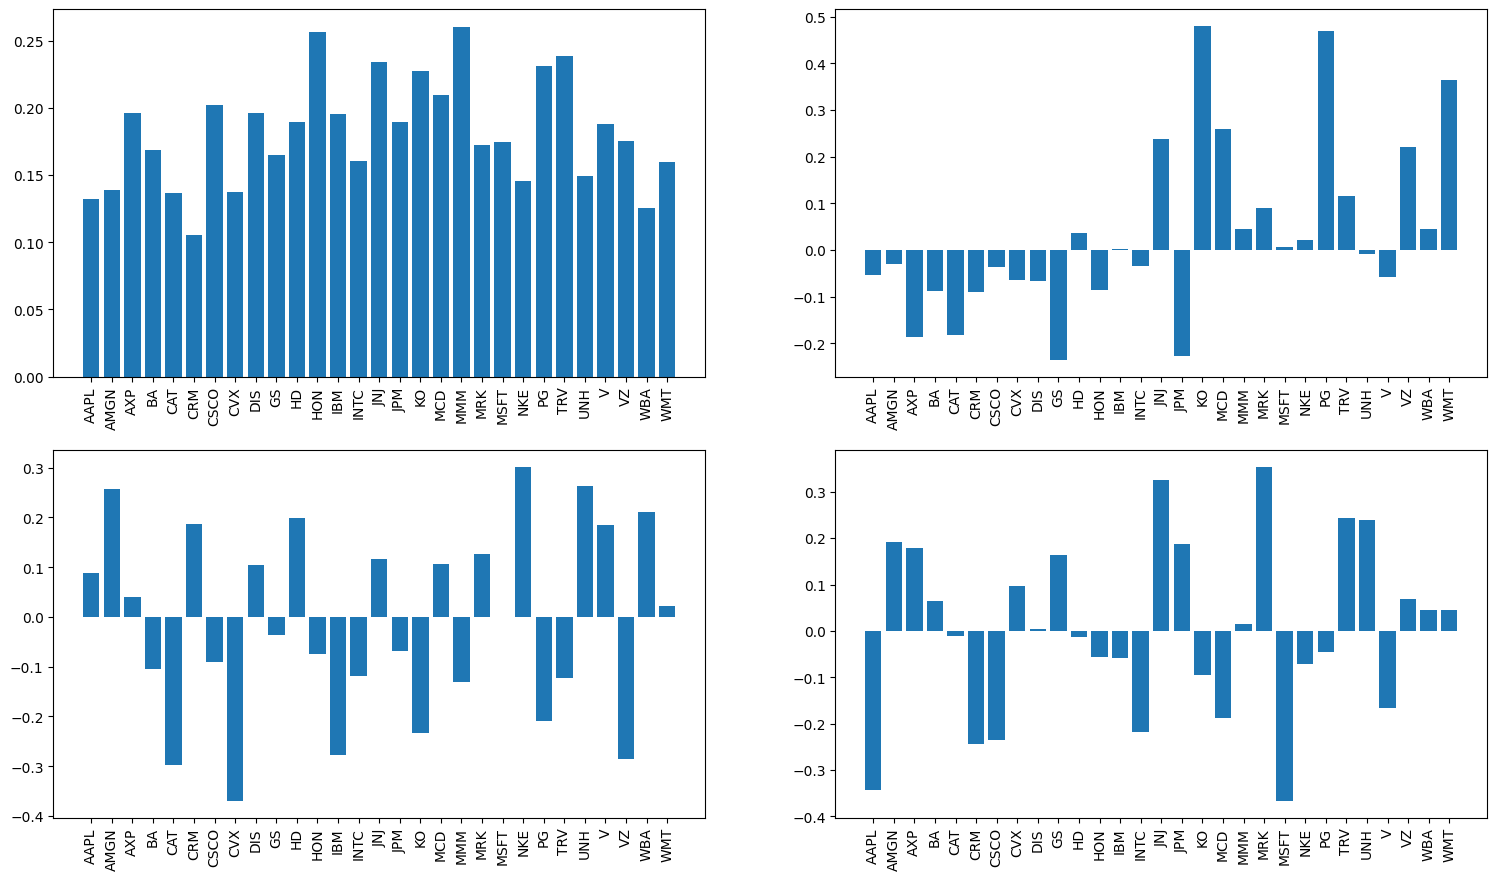

In [246]:
fig, axes = plt.subplots(2,2,sharex=False)

axes[0,0].bar(np.arange(29),
              (DJI_evecs_std[:,0]/np.linalg.norm(DJI_evecs_std[:,0])),
             tick_label=DJI_train.columns);
axes[0,1].bar(np.arange(29),(DJI_evecs_std[:,1]/np.linalg.norm(DJI_evecs_std[:,1])),
             tick_label=DJI_train.columns);
axes[1,0].bar(np.arange(29),(DJI_evecs_std[:,2]/np.linalg.norm(DJI_evecs_std[:,2])),
             tick_label=DJI_train.columns);
axes[1,1].bar(np.arange(29),(DJI_evecs_std[:,3]/np.linalg.norm(DJI_evecs_std[:,3])),
             tick_label=DJI_train.columns);

#axes[0,0].set_xticks(np.arange(29),labels=list(DJI_train.columns),rotation=45);

for i in range(2):
    for j in range(2):
        axes[i,j].set_xticklabels(DJI_train.columns,rotation=90)

fig.set_size_inches(18.5, 10.5)
#axes[0,0].set_xlabel('ticker')
#axes[0,0].set_xticks(np.arange(29));
#axes[0,0].set_xticklabels(DJI_train.columns,rotation=90);

In [247]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It computes the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of an eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

In [262]:
sharpe_ratio(SP_eport_train.iloc[:,0])

(-0.5205260761896, 1.1896819839893091, -0.43753379743058934)

In [249]:
sharpe_ratio(SP_eport_train[0])

(-0.5205260761896, 1.1896819839893091, -0.43753379743058934)

In [266]:
SP_eport_train.index[-1]

Timestamp('2017-12-28 00:00:00')

In [268]:
SP_eport[0].loc[:SP_eport_train.index[-1]].pct_change().dropna()

Date
2014-01-03    0.001407
2014-01-06    0.005923
2014-01-07   -0.000666
2014-01-08    0.000369
2014-01-09    0.007559
                ...   
2017-12-21    0.019897
2017-12-22   -0.003999
2017-12-26   -0.002803
2017-12-27   -0.004303
2017-12-28    0.016614
Name: 0, Length: 1005, dtype: float64

In [270]:
SP_eport_train[0]

Date
2014-01-03   -0.064611
2014-01-06   -0.027731
2014-01-07   -0.058832
2014-01-08   -0.021406
2014-01-09   -0.016222
                ...   
2017-12-21   -0.008501
2017-12-22    0.111861
2017-12-26    0.045505
2017-12-27   -0.009272
2017-12-28   -0.105974
Name: 0, Length: 1005, dtype: float64

# Dimensionality Reduction

In [155]:
SP_train_reconst = PCA_SP.inverse_transform(PCA_SP.transform(SP_train_scaled))
SP_test_reconst = PCA_SP.inverse_transform(PCA_SP.transform(SP_test_scaled))

DJI_train_reconst = PCA_DJI.inverse_transform(PCA_DJI.transform(DJI_train_scaled))
DJI_test_reconst = PCA_DJI.inverse_transform(PCA_DJI.transform(DJI_test_scaled))

In [156]:
np.allclose((pd.DataFrame(SP_train_reconst,
             columns=SP_train_scaled.columns,
            index = SP_train_scaled.index).corr()-SP_train_scaled.corr()).values,
            np.zeros((SP_train_scaled.shape[1],SP_train_scaled.shape[1])))

True

In [157]:
(pd.DataFrame(SP_test_reconst,
              columns=SP_test_scaled.columns,
              index = SP_test_scaled.index).corr()-SP_test_scaled.corr()).values

array([[ 0.00000000e+00, -7.21644966e-16, -4.44089210e-16, ...,
         4.44089210e-16,  1.05471187e-15,  3.33066907e-16],
       [-7.21644966e-16,  0.00000000e+00, -8.32667268e-16, ...,
        -3.88578059e-16, -5.55111512e-17, -1.11022302e-15],
       [-4.44089210e-16, -8.32667268e-16,  0.00000000e+00, ...,
         1.11022302e-16,  3.33066907e-16, -2.22044605e-16],
       ...,
       [ 4.44089210e-16, -3.88578059e-16,  1.11022302e-16, ...,
         0.00000000e+00,  1.16573418e-15,  3.33066907e-16],
       [ 1.05471187e-15, -5.55111512e-17,  3.33066907e-16, ...,
         1.16573418e-15,  0.00000000e+00, -2.77555756e-16],
       [ 3.33066907e-16, -1.11022302e-15, -2.22044605e-16, ...,
         3.33066907e-16, -2.77555756e-16,  0.00000000e+00]])

In [130]:
SP_train_scaled.shape

(1005, 470)